# Welcome to an example Binder

This notebook uses `seaborn`, which we have because we included it in our `requirements.txt` file

## Setup our plotting

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Setup our imports

In [2]:
from pyproj import Geod
import geojson
import requests

In [37]:
def getElevation(lon, lat):
    params = {'latitude' : lat, 'longitude' : lon, 'format' : 'json'} # geojson | text/plain
    url = 'https://www.gmrt.org/services/PointServer'
    resp = requests.get(url, params = params)
    return float(resp.json()['elevation'])

In [33]:
print(resp.text)

{"longitude":"-126.872152","latitude":"48.699937","elevation":"-1316"}


## Setup pyproj
[see](http://pyproj4.github.io/pyproj/html/api/geod.html)


In [77]:
g = Geod(ellps='WGS84')

## Plate motion
First order plate motions can be computed using the [euler_pole](https://github.com/joferkington/euler_pole) Python package and the poles found in [Kreemer et al., 2014](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014GC005407).

The results are similar but not identical to the UNAVCO plate calculator.

In [5]:
from euler_poles import EulerPole

In [11]:
JF_PA = EulerPole(lat=-0.60, lon=37.80, rate=0.625)
NA_PA = EulerPole(lat=49.30, lon=-76.01, rate=0.791)
JF = JF_PA - NA_PA
print(JF.velocity_components(lat=48.6999,lon=-126.8722))
print(JF.velocity(lat=48.6999,lon=-126.8722))
#32.65   26.09
#41.79	51.37°
#41.78	51.37°

(33.057235679410034, 26.116788007650868, 2.713542284593533)
(51.689587033662825, 42.2164749633471)


In [94]:
class Site():
    def __init__(self,name, lon, lat, elev = None):
        self.name = name
        self.lon = lon
        self.lat = lat
        if not elev == None:
            self.elev = elev
        else:
            self.elev = getElevation(self.lon, self.lat)
    
    def __str__(self):
        return '%s -- lon: %f, lat: %f, elev %f' % (self.name, self.lon, self.lat, self.elev)
    
    def __repr__(self):
        return self.__str__()
    
    
    def velocity_components(self):
        return JF.velocity_components(lon = self.lon, lat = self.lat)
    
    def velocity(self):
        return JF.velocity(lon = self.lon, lat = self.lat)
            
            
s = Site('CORK 1364A', lon = -126.872152,lat = 48.699937)        

In [95]:
refSites = [s,]
for i in range(1, 6):
    az,v = s.velocity()
    lon,lat,_ = g.fwd(s.lon,s.lat, az-90., 20e3)
    s = Site('Along %d km' % (20*i), lon = lon,lat = lat)
    refSites.append(s)

s = refSites[0]
for i in range(1, 6):
    az,v = s.velocity()
    lon,lat,_ = g.fwd(s.lon,s.lat, az-90., -20e3)
    s = Site('Along %d km' % (-20*i), lon = lon,lat = lat)
    refSites.append(s)


In [98]:
sorted(refSites, key=lambda x: x.lat)

[Along -100 km -- lon: -126.041561, lat: 47.991273, elev -1530.000000,
 Along -80 km -- lon: -126.205851, lat: 48.133487, elev -1748.000000,
 Along -60 km -- lon: -126.371046, lat: 48.275463, elev -2058.000000,
 Along -40 km -- lon: -126.537156, lat: 48.417199, elev -1507.000000,
 Along -20 km -- lon: -126.704189, lat: 48.558691, elev -1538.000000,
 CORK 1364A -- lon: -126.872152, lat: 48.699937, elev -1316.000000,
 Along 20 km -- lon: -127.041057, lat: 48.840934, elev -1859.000000,
 Along 40 km -- lon: -127.210909, lat: 48.981679, elev -2066.000000,
 Along 60 km -- lon: -127.381717, lat: 49.122172, elev -1931.000000,
 Along 80 km -- lon: -127.553489, lat: 49.262408, elev -1847.000000,
 Along 100 km -- lon: -127.726234, lat: 49.402385, elev -1756.000000]

# Plate motion
Plate motions are calculated using [UNAVCO Plate Motion Calculator](https://www.unavco.org/software/geodetic-utilities/plate-motion-calculator/plate-motion-calculator.html)

Input coordinates:

    -127.157 48.25721 -2500 #1,
    -127.639 48.79599 -2500 #8,
    -126.8722 48.6999 1200 CORK 1364A,
    -126.1733 48.4278 400 BC-US,
    -125.8918 49.2267 0 CQS-Shore,
    -127.345 48.90984 -1200 #9

* Model GSRM 2.1 (2014)
* Plate motion (JdF)
* Relative to NA

Results:

    -127.157000  48.257210   31.61   26.59 0 0 0 JF(NA) GSRM v2.1 #1
    -127.639000  48.795990   32.56   27.45 0 0 0 JF(NA) GSRM v2.1 #8
    -126.872200  48.699900   32.65   26.09 0 0 0 JF(NA) GSRM v2.1 CORK 1364A
    -126.173300  48.427800   32.31   24.83 0 0 0 JF(NA) GSRM v2.1 BC-US
    -125.891800  49.226700   34.06   24.32 0 0 0 JF(NA) GSRM v2.1 CQS-Shore
    -127.345000  48.909840   32.91   26.93 0 0 0 JF(NA) GSRM v2.1 #9




In [191]:
n_start = g.fwd()

TypeError: fwd() missing 4 required positional arguments: 'lons', 'lats', 'az', and 'dist'

## JdF Plate depth contours
https://pubs.usgs.gov/ds/91/
https://pubs.usgs.gov/ds/91/4_DATA/ASCII_GIS_DATA/slab_contours_GCS_WGS84.txt

In [41]:
dat = requests.get('https://pubs.usgs.gov/ds/91/4_DATA/ASCII_GIS_DATA/slab_contours_GCS_WGS84.txt').text

In [ ]:
geojson.LineString(coordinates=)

In [105]:
features = []
for block in dat.split('END'):
    lines = block.split('\r')
    coords = []
    for line in lines:
        try:
            coord = (float(line.split()[1]),float(line.split()[0]))
            if coord:
                coords.append(coord)
                tag = float(line.split()[2])
        except:
            pass
    if coords:
        #print(coords)
        l_str = geojson.LineString(coordinates = coords)
        feature = geojson.Feature(geometry=l_str,properties={'depth' : str(tag)})
        features.append(feature)
        
f_collection = geojson.FeatureCollection(features)
    
    


In [106]:
with open('test.geojson','w') as geofile:
    geojson.dump(f_collection, geofile,indent=4, sort_keys=True)


In [102]:
#dat.split('END')
coord

(38.98736, -121.52941)

In [3]:
import georasters as gr

C:\Users\mheesema\AppData\Local\Continuum\anaconda3\envs\work3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


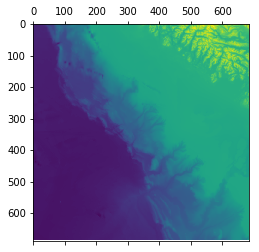

In [4]:
#gmrt = gr.from_file('D:/Backup/Documents/Maps/Bathymetry/GMRTv3_2_20161001topo.tif')
#https://www.gmrt.org/services/GridServer?minlongitude=-128&maxlongitude=-125&minlatitude=47.5&maxlatitude=49.5&format=geotiff&resolution=default&mresolution=10&layer=topo

raster = 'G:/My Drive/Archive/W540-Downloads/GMRTv3_6_20190410topo.tif'
#raster = 'D:/Backup/Documents/Maps/NCSZO/Thomson_WGS84.tif'
gmrt = gr.from_file(raster)
gmrt.plot()


In [111]:
gmrts = gmrt.extract(-126.87,48.66,radius=1.0)

In [119]:
gmrt.map_pixel(-126.87,48.66)


-1346.8833

In [138]:
print(gmrt.shape)
print(gmrt.bounds)


(690, 684)
(-128.00610673270498, 47.494963302421894, -124.99584639229502, 49.50669419550329)


In [135]:
print((gmrts.bounds[2]-gmrts.bounds[0])*111)
222/693

222.08816498957617


0.3203463203463203

In [158]:
gr.get_geo_info(raster)


(None,
 684,
 690,
 (-128.00610673270498,
  0.004400965409956076,
  0.0,
  49.50669419550329,
  0.0,
  -0.0029155520189585444),
 <osgeo.osr.SpatialReference; proxy of <Swig Object of type 'OSRSpatialReferenceShadow *' at 0x000001B6AB66CD20> >,
 'Float32')

In [161]:
gmrt[0,0]

AttributeError: 'int' object has no attribute 'start'

In [190]:
gmrt.map_pixel_location(-127.0114885500549, 48.002269353720685)
#gmrt.map_pixel_location(-128.00610673270498, 49.50669419550329)

array([515, 225])

In [168]:
gmrt.bounds

(-128.00610673270498,
 47.494963302421894,
 -124.99584639229502,
 49.50669419550329)

In [177]:
(gmrt.bounds[0]+226*gmrt.x_cell_size,gmrt.bounds[3]+516*gmrt.y_cell_size)

(-127.0114885500549, 48.002269353720685)

In [189]:
(gmrt.bounds[0], gmrt.x_cell_size,gmrt.bounds[3], gmrt.y_cell_size)

(-128.00610673270498,
 0.004400965409956076,
 49.50669419550329,
 -0.0029155520189585444)

In [178]:
gmrt.map_pixel(-127.0114885500549, 48.002269353720685)

-2541.1448

In [184]:
gmrt.raster[0,0]

-2405.7412

For equilateral triangles with side length $s$ the radius of the circumcircle is given by the formula:
$ r = s/\sqrt{3} $ [see](https://www.mathopenref.com/trianglecircumcircle.html)

Therefore, if the transponders are to be located on a circle with the radius of the waterdepth z, the length of the triangle is $s = z \sqrt{3}$



In [5]:
import numpy as np

In [85]:
g = Geod(ellps='WGS84')
def getStationQuality(lon = -126.6960, lat = 48.8109, manual= True):
    d_r = 250. 

    # define centre index
    #x=100
    #y=100
    #(y,x) = gmrt.map_pixel_location(-126.888262, 48.675762)

    # Get coordinates
    p_0 ={}
    #p_0['lon'] = gmrt.bounds[0]+x*gmrt.x_cell_size
    #p_0['lat'] = gmrt.bounds[3]+y*gmrt.y_cell_size
    #z_0 = gmrt.raster[x,y]

    (p_0['lon'], p_0['lat']) = (lon,lat)

    z_0 = gmrt.map_pixel(p_0['lon'],p_0['lat'])

    d_phi = abs(360 / (2 * np.pi * z_0 / d_r))
    phis = np.arange(0.,360.,d_phi)
    
    ones = np.ones(phis.shape)

    #g.fwd([-127.0114885500549,-127.0114885500549], [48.002269353720685,48.002269353720685],[0,30],[1200.,1200.])
    p_1 = {}
    p_2 = {}
    [p_1['lons'],p_1['lats'],_] = g.fwd(ones*p_0['lon'], ones*p_0['lat'],phis,ones*z_0*np.sqrt(3))
    z1s = gmrt.map_pixel(p_1['lons'],p_1['lats'])
    [p_2['lons'],p_2['lats'],_] = g.fwd(ones*p_0['lon'], ones*p_0['lat'],phis+60.,ones*z_0*np.sqrt(3))
    z2s = gmrt.map_pixel(p_2['lons'],p_2['lats'])

    max_diff = np.max(np.array([np.abs(z1s-z_0),np.abs(z2s-z_0)]),0)
    
    if manual:
        print(p_0, z_0, d_phi)
        print(gmrt.map_pixel(p_0['lon'],p_0['lat']))
        print(gmrt.map_pixel_location(p_0['lon'],p_0['lat']))
        best = np.argmin(max_diff)
        fig=plt.figure(1)
        fig.clf()
        ax = plt.gca()
        max_diff[max_diff > 3000] = np.nan
        plt.plot(phis,max_diff)
        plt.plot(phis[best],max_diff[best],'ko')
        plt.plot(phis,z1s-z_0)
        plt.plot(phis,z2s-z_0)
        plt.grid(True)
        #ax.set_ylim(-50,50)

        print(max_diff[best])
        print(4*'%f, %f,\n' % (p_0['lon'],p_0['lat'],
                              p_1['lons'][best],p_1['lats'][best],
                              p_2['lons'][best],p_2['lats'][best],
                              np.mean([p_0['lon'],p_1['lons'][best],p_2['lons'][best]]),
                              np.mean([p_0['lat'],p_1['lats'][best],p_2['lats'][best]])))
    return np.min(max_diff)

{'lon': -127.1148, 'lat': 49.0115} -1651.7738 8.671856186416
-1651.7738
[169 202]
2.6888428
-127.114800, 49.011500,
-127.125082, 49.036321,
-127.087250, 49.029762,
-127.109044, 49.025861,

Wall time: 23 ms


2.6888428

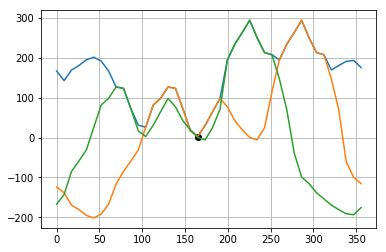

In [91]:
%%time
getStationQuality(-127.1148,49.0115, manual = True)

In [246]:
np.argmin(np.max(np.array([np.abs(z1s-z_0),np.abs(z2s-z_0)]),0))

25

x,y

In [79]:
mygrd = gmrt.copy()
mygrd.raster[:] = np.nan
mygrd.nodata_value = np.nan


In [80]:
count = 0
for lon in np.arange(gmrt.bounds[0],gmrt.bounds[2],gmrt.x_cell_size): #gmrt.x_cell_size
    for lat in np.arange(gmrt.bounds[1],gmrt.bounds[3],-gmrt.y_cell_size): # -gmrt.y_cell_size
        #qual = getStationQuality(lon, lat, manual = False)
        try:
            z = gmrt.map_pixel(lon, lat)
            if z > -800 or z < -2300:
                # to deep or shallow to be interesting
                continue
            #print(z)
            (x,y) = gmrt.map_pixel_location(lon, lat)
            #print(x,y)
            qual = getStationQuality(lon, lat, manual = False)
            #print(qual)
            if np.isfinite(qual) and qual < 30:
                mygrd.raster[x,y] = qual
                count += 1
        except:
            pass
            #print(lon, lat)
        
#print(gmrt.raster[347, 454])
#print(gmrt.map_pixel(-126.00610673270498, 48.494963302421894))
#gmrt.map_pixel(-126.00610673270498, 48.494963302421894)

C:\Users\mheesema\AppData\Local\Continuum\anaconda3\envs\work3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
C:\Users\mheesema\AppData\Local\Continuum\anaconda3\envs\work3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


63608

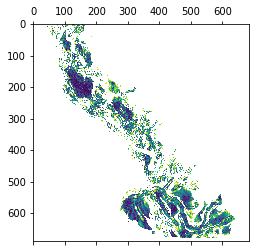

In [87]:
mygrd.plot()
count



In [88]:
mygrd.to_tiff('StationQuality.tif')

In [65]:
np.all(np.isfinite(mygrd.raster.data))


True

In [71]:
mygrd.nodata_value = np.nan